*(Source : Julian Avila, Trent Hauck. Scikit-learn cookbook. Packt publishing Ltd.)*

# Introduction

Les variables explicatives (ou features) considérées dans une analyse multidimensionnelles sont souvent inutilement nombreuses :
- des variables peuvent être fortement corrélées entre elles (comme la température à Bâle et celle à Dijon), et donc il est inutile de toutes les garder;
- des variables explicatives peuvent avoir peu ou pas d'impact sur la variable à expliquer.
Et l'apprentissage est plus aisé avec un plus faible nombre de variables.

Aussi, réduire le nombre de variables explicatives (les features) s'avère souvent très utile pour améliorer la qualité de l'apprentissage. D'autre part, réduire fortement la dimension permet de produire ensuite des représentations graphiques plus facilement interprétables.

Diverses techniques existent pour cela, telles que l'analyse en composantes principales, la décomposition en valeurs singulières tronquée, ou encore le t-SNE. Elles vont être étudiées ci-après.

# Réduction de dimension par ACP

Nous avons vu précédemment qu'une fleur, dans la base de données iris, est constituée de 4 valeurs (longueur et largeur des pétales et sépales). Chaque plante est donc ici un point dans un espace à 4 dimensions. 

Pour visualiser ce nuage de points, nous avions considéré deux graphes (à 2 dimensions chacun) : celui des longueurs-largeurs de pétales, et celui des longueurs-largeurs de sépales. On comprend que ce procédé a ses limites : si, au lieu de 4 variables, on en avait 400, ce regroupement 2 par 2 conduirait à 200 graphes, ce qui ne nous renseignerait en rien.

Comme nous allons le voir, l'analyse ne composantes principales permet d'apporter une réponse à ce problème de représentation. Importons le module decomposition de sklearn, et instancions un objet PCA :

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA()

Réimportons les données :

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

Réalisons à présent une ACP de nos iris :


In [ ]:
iris_pca = pca.fit_transform(X)
iris_pca[:5]

array([[-2.68420713e+00,  3.26607315e-01, -2.15118370e-02,
         1.00615724e-03],
       [-2.71539062e+00, -1.69556848e-01, -2.03521425e-01,
         9.96024240e-02],
       [-2.88981954e+00, -1.37345610e-01,  2.47092410e-02,
         1.93045428e-02],
       [-2.74643720e+00, -3.11124316e-01,  3.76719753e-02,
        -7.59552741e-02],
       [-2.72859298e+00,  3.33924564e-01,  9.62296998e-02,
        -6.31287327e-02]])

On voit que l'on reste à la base en dimension 4. Cependant...

In [ ]:
pca.explained_variance_ratio_

array([0.92461621, 0.05301557, 0.01718514, 0.00518309])

Les premières variables concentrent dorénavant la plus grande variance au niveau des données : on a changé de vecteurs de base, orthogonale, de sorte que les données varient le plus suivant la première coordonnée, puis le plus suivant la seconde...

On peut, à l'aide de l'ACP, représenter les données dans un espace de plus faible dimension (ici, dimension 2 : un plan) :

In [ ]:
pca = decomposition.PCA(n_components=2)
iris_X = pca.fit_transform(X)
iris_X.shape

(150, 2)

... qui concentre cependant la plus grande partie de la variance du nuage de points :

In [ ]:
pca.explained_variance_ratio_.sum()

0.9776317750248034

On peut afficher le nuage de points avant et après transformation ACP :

Text(0.5,1,'Après PCA')

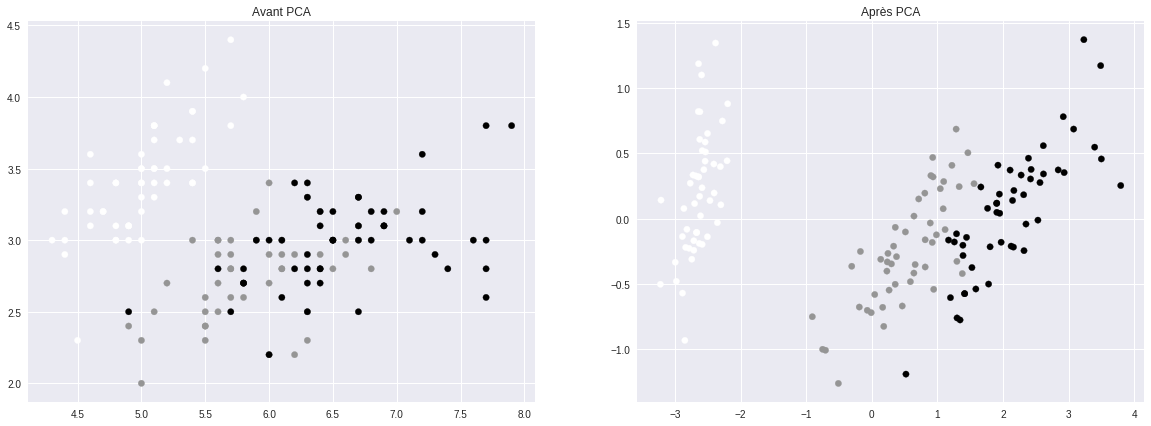

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(121)
ax.scatter(X[:,0],X[:,1],c=y,s=40)
ax.set_title('Avant PCA')

ax2 = fig.add_subplot(122)
ax2.scatter(iris_X[:,0],iris_X[:,1],c=y,s=40)
ax2.set_title('Après PCA')

On obtient une meilleure séparation du nuage de points !

Les ACP, il vaut mieux les faire sur les données normalisées, afin de ne pas avoir de variances liées aux unités différentes. On en vient à la constitution d'un pipeline : d'abord normaliser les données, puis les transformer.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca',decomposition.PCA(n_components=2))])

iris_X_scaled = pipe.fit_transform(X)

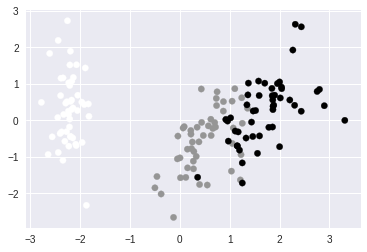

In [ ]:
plt.scatter(iris_X_scaled[:,0],iris_X_scaled[:,1],c=y,s=40)


# L'ACP à noyau

Plutôt que de faire des projections linéaires comme dans l'ACP, on peut utiliser l'astuce d'un noyau projettant implicitement les observations dans un espace de très grande dimension. Cela permet au final de faire des projections non linéaires.

Supposons par exemple que notre nuage de points des variables explicatives s'étend suivant deux cercles, chacun associé à une valeur de la variable à expliquer (rouge ou bleu), comme ci-dessous :

Text(0,0.5,'$x_2$')

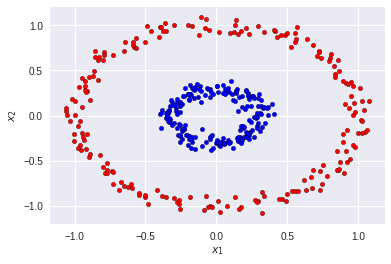

In [ ]:
from sklearn.datasets import make_circles

X_cercle, y_cercle = make_circles(n_samples=400, factor=.3, noise=.05)
rouge = y_cercle == 0
bleu  = y_cercle == 1

plt.scatter(X_cercle[rouge, 0], X_cercle[rouge, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_cercle[bleu, 0], X_cercle[bleu, 1], c="blue",
            s=20, edgecolor='k')

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

L'ACP ne parvient pas à améliorer la représentabilité de ces données :

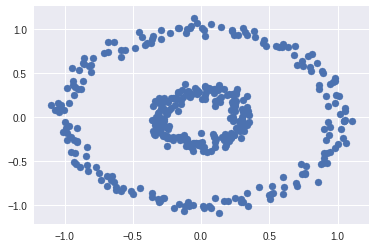

In [ ]:
pca = decomposition.PCA()
X_pca = pca.fit_transform(X_cercle)
plt.scatter(X_pca[:, 0], X_pca[:, 1])

Mais si on passe un noyau de type RBF, alors on voit apparaître une séparation de variables :

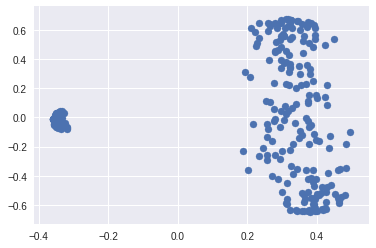

In [ ]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(kernel="rbf", gamma=7)
X_kpca = kpca.fit_transform(X_cercle)
plt.scatter(X_kpca[:, 0], X_kpca[:, 1])

Les noyaux disponibles : linear, poly, rbf, sigmoid, cosine, et precomputed.

# La SVD tronquée

Sans rentrer dans les détails, l'ACP réalise une factorisation de la matrice de covariance des variables explicatives. La décomposition en valeurs singulières (SVD), quant à elle, effectue une factorisation matricielle U*S*V directement sur la matrice des données.

Comparée à la SVD classique, la SVD tronquée réalise cette factorisation en produisant des matrices ayant le nombre de colonnes spécifiées.

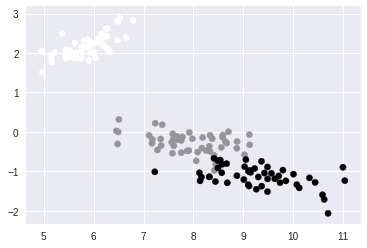

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(2)
iris_svd = svd.fit_transform(X)
plt.scatter(iris_svd[:,0],iris_svd[:,1],c=y,s=40)

# L'analyse factorielle

L'analyse factorielle est une méthode statistique utilisée pour décrire la variabilité des variables observées et corrélées en fonction d'un nombre potentiellement inférieur de variables non observées appelées facteurs.

Par exemple, il est possible que les variations de six variables observées reflètent principalement les variations de deux variables non observées (sous-jacentes). L'analyse factorielle recherche de telles variations jointes en réponse à des variables latentes non observées. 

Cette analyse factorielle se fait, avec sklearn, d'une manière semblable à une ACP :

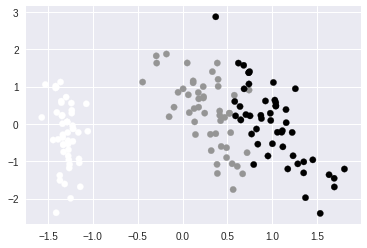

In [ ]:
from sklearn.decomposition import FactorAnalysis
fa = FactorAnalysis(n_components=2)
iris_fa = fa.fit_transform(X)
plt.scatter(iris_fa[:,0],iris_fa[:,1],c=y,s=40)

L'analyse factorielle est similaire à l'ACP. Cependant, l'ACP est une transformation linéaire des données dans un espace différent, où la première composante explique la variance des données, et chaque composante suivante est orthogonale à la première composante (on peut voir l'ACP comme passer d'un ensemble de données de N dimensions à un espace de M dimensions, où M < N).

L'analyse factorielle, en revanche, part du principe qu'il n'y a que M caractéristiques importantes et qu'une combinaison linéaire de ces caractéristiques (plus le bruit) crée l'ensemble de données dans N dimensions. 

# Autres techniques de réduction de dimension

## La méthode t-SNE

La méthode t-SNE (t-distributed Stochastic Neighbor Embedding) effectue une réduction de dimension tout en essayant de conserver les observations semblables proches, et les observations dissemblables éloignées. Cette méthode est surtout utilisée pour la visualisation.

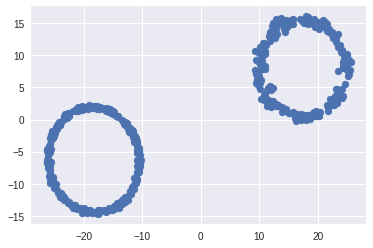

In [ ]:
from sklearn.manifold import TSNE
cercle_tsne = TSNE(learning_rate=200).fit_transform(X_cercle)
plt.scatter(cercle_tsne[:, 0], cercle_tsne[:, 1])

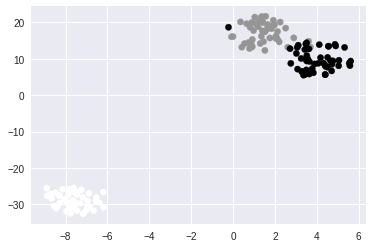

In [ ]:
iris_tsne = TSNE(learning_rate=200).fit_transform(X)
plt.scatter(iris_tsne[:, 0], iris_tsne[:, 1],c=y,s=40)

## La méthode Isomap

Cette méthode crée un graphe en connectant chaque observation à ses plus proches voisins, puis effectue une réduction de dimension en s'efforçant de préserver les distances géodésiques entre les observations.

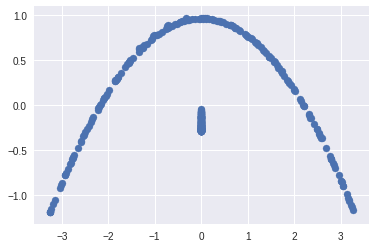

In [ ]:
from sklearn.manifold import Isomap
cercle_ISO = Isomap(n_components = 2).fit_transform(X_cercle)
plt.scatter(cercle_ISO[:, 0], cercle_ISO[:, 1])

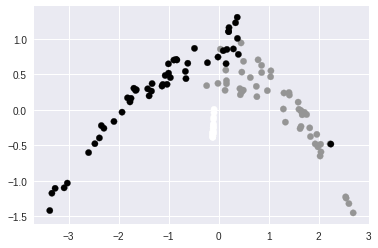

In [ ]:
iris_ISO = Isomap(n_components = 2).fit_transform(X)
plt.scatter(iris_ISO[:, 0], iris_ISO[:, 1], c=y, s=40)

## Le Positionnement Multidimensionnel

Cette technique appellée MDS (multidimentional scaling) réduit la dimension tout en s'efforçant de préserver les distances entre observations.

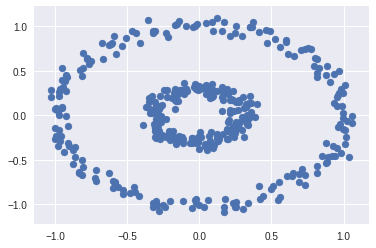

In [ ]:
from sklearn.manifold import MDS
cercle_MDS = MDS(n_components = 2).fit_transform(X_cercle)
plt.scatter(cercle_MDS[:, 0], cercle_MDS[:, 1])

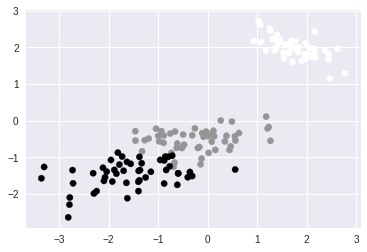

In [ ]:
iris_MDS = MDS(n_components = 2).fit_transform(X)
plt.scatter(iris_MDS[:, 0], iris_MDS[:, 1], c=y, s=40)

## DictionaryLearning

On peut utiliser une méthode de décomposition pour la classification. DictionaryLearning prend un ensemble de données et tente de le transformer en une représentation "sparse" (i.e., avec beaucoup de zéros).

Il s'agit d'une  méthode d'apprentissage de la représentation issue du traitement du signal, qui vise à trouver une représentation clairsemée (sparse) des données d'entrée, sous la forme d'une combinaison linéaire d'éléments de base ainsi que de ces éléments de base eux-mêmes. Ces éléments sont appelés atomes et composent un dictionnaire. 

Cette représentation permet également que la dimensionnalité des signaux représentés soit supérieure à celle des signaux observés. Les deux propriétés ci-dessus conduisent à avoir des atomes apparemment redondants qui permettent des représentations multiples d'un même signal, mais aussi une amélioration de la sparsité et de la flexibilité de la représentation. 


Séparons notre jeu de données d'iris en 2 : une ligne sur 2 pour l'entraînement, et une sur deux pour le test :

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train = X[::2]
X_test = X[1::2]
y_train = y[::2]
y_test = y[1::2]

Vérifions que c'est bien cela qui est fait :

In [ ]:
X[:7]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3]])

In [ ]:
X_train[:7]

array([[5.1, 3.5, 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [4.6, 3.4, 1.4, 0.3],
       [4.4, 2.9, 1.4, 0.2],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3. , 1.4, 0.1]])

In [ ]:
X_test[:7]

array([[4.9, 3. , 1.4, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [5. , 3.4, 1.5, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [4.8, 3.4, 1.6, 0.2],
       [4.3, 3. , 1.1, 0.1]])

On suppose que l'on sait qu'il y a 3 espèces d'iris dans notre jeu de données. On peut donc instancier un objet DictionaryLearning avec 3 comme paramètre :

In [ ]:
from sklearn.decomposition import DictionaryLearning
dl = DictionaryLearning(3)

On peut alors appliquer la méthode fit_transform sur notre ensemble d'entraînement : chaque ligne de nos données sera tranformée en un vecteur de taille 3, correspondant aux 3 types de fleurs. La représentation sera sparse, avec un maximum correspondant au type de fleurs le plus probable :

In [ ]:
transformee = dl.fit_transform(X_train)
transformee[:5]

array([[0.        , 6.34476574, 0.        ],
       [0.        , 5.83576461, 0.        ],
       [0.        , 6.32038375, 0.        ],
       [0.        , 5.89318572, 0.        ],
       [0.        , 5.45222715, 0.        ]])

On retrouve bien une représentation sparse. Et si seule la seconde colonne a des valeurs non nulles, c'est parce que les données sont triées par type de fleurs dans notre base de données.

Regardons les prédictions sur notre base de tests : on en obtient une représentation sparse en dimension 3.

In [ ]:
test_transform = dl.transform(X_test)

Puis on représente graphiquement ce qui a été prédit.

Text(0.5,0.92,'Testing Set')

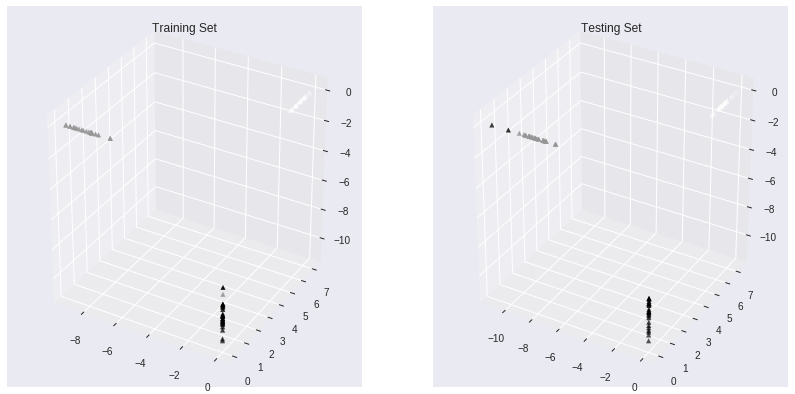

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(transformee[:,0],transformee[:,1],transformee[:,2],c=y_train,marker = '^')
ax.set_title("Ensemble d'apprentissage")
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(test_transform[:,0],test_transform[:,1],test_transform[:,2],c=y_test,marker = '^')
ax2.set_title("Ensemble de test")

On voit comment les données ont été transformées, et aussi qu'il y a quelques erreurs de classification.

# Comparaison de méthodes

Nous allons maintenant comparer diverses techniques de réduction de dimension à deux types de classifieurs de type machines à support de vecteurs : SVC et LinearSVC. Les techniques de réduction de dimension retenues ici sont : l'analyse en composantes principales (PCA), la SVD tronquée (TruncatedSVD), la méthode Isomap, et la factorisation en matrices non-négatives (NMF).

Importons cette dernière, ainsi que de quoi faire un pipeline de traitement, que l'on initialise avec la PCA pour la réduction de dimension, et le SVC pour classification.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.svm import SVC, LinearSVC

pipe = Pipeline([
    ('reduc_dim', PCA()),
    ('classif', SVC())
])


On définit maintenant notre grille de recherche de l'optimum : on veut rechercher sur les 4 méthodes de réduction de dimension et les 2 classifieurs, mais aussi sur les dimensions 2 et 3, et sur 4 valeurs pour le paramètre C des classifieurs :


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{
'reduc_dim': [PCA(), NMF(),Isomap(),TruncatedSVD()],
'reduc_dim__n_components': [2, 3],
'classif' : [SVC(), LinearSVC()],
'classif__C': [1, 10, 100, 1000]
},
]

Il nous reste maintenant à faire la recherche de l'optimum :

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()

grid = GridSearchCV(pipe, cv=3, n_jobs=-1, param_grid=param_grid)
grid.fit(iris.data, iris.target)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('reduc_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classif', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'reduc_dim': [PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=None, random_state=None, shuffle=False, solver='cd',
  tol=0...', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)], 'classif__C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
    

On peut demander quel couple de réduction de dimension suivi de classification a le mieux marché :

In [ ]:
grid.best_params_

{'classif': LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0),
 'classif__C': 10,
 'reduc_dim': TruncatedSVD(algorithm='randomized', n_components=3, n_iter=5,
        random_state=None, tol=0.0),
 'reduc_dim__n_components': 3}

In [ ]:
grid.best_score_

0.9866666666666667

Dans 98,66% des cas, on a donc réussi à bien classifier (erreur moyenne de précision, ou Mean Accuracy Error, sur l'ensemble d'apprentissage).